In [1]:
!pip install wandb > /dev/null 2>&1

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
import joblib
import wandb
import os


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
import tensorflow as tf


## Carregando o dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
samples, w, h = x_train.shape

print(f'{samples} in the training dataset with dimension {w}x{h}')

samples, w, h = x_test.shape

print(f'{samples} in the test dataset with dimension {w}x{h}')

60000 in the training dataset with dimension 28x28
10000 in the test dataset with dimension 28x28


## EDA

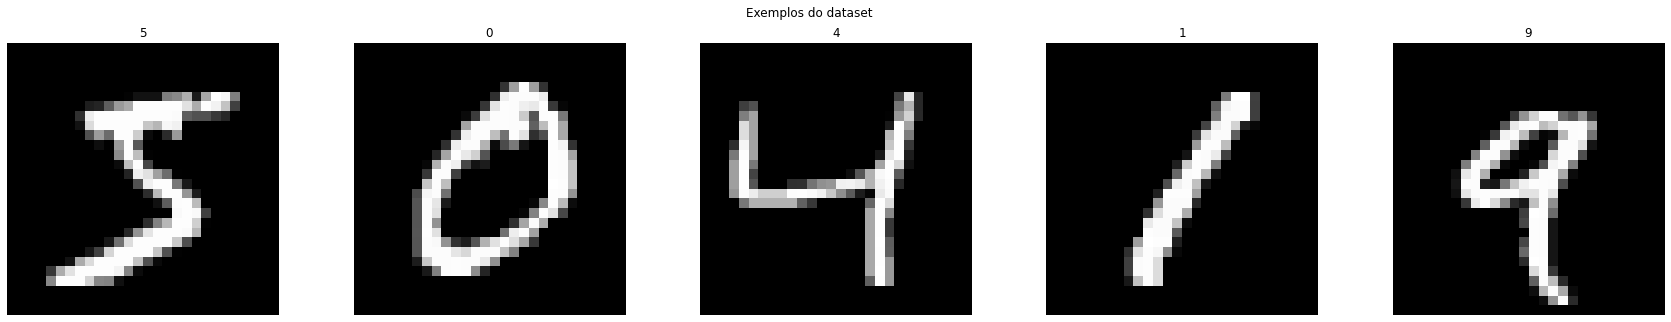

In [5]:
fig, ax = plt.subplots(ncols=5, figsize=(30, 5))

for idx, image in enumerate(x_train[:5]):

    ax[idx].imshow(image, cmap='gray')
    ax[idx].axis('off')

    ax[idx].set_title(f'{y_train[idx]}')

fig.suptitle('Exemplos do dataset')

plt.show()

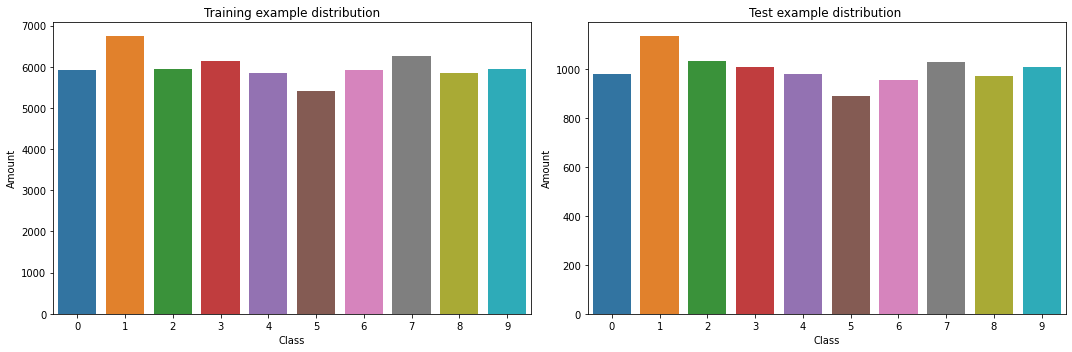

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

sns.countplot(x=y_train, ax=ax[0])
ax[0].set(
    title='Training example distribution',
    xlabel='Class',
    ylabel='Amount'
)

sns.countplot(x=y_test, ax=ax[1])
ax[1].set(
    title='Test example distribution ',
    xlabel='Class',
    ylabel='Amount'
)

plt.tight_layout()
plt.show()

## Modelo MLP Baseline

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train.reshape((-1,1)))

In [8]:
mlp = Sequential([
    Input(shape=(28,28)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.15),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

mlp.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trai

In [9]:
history = mlp.fit(
    x_train, y_train,
    validation_split=0.1,
    batch_size=64,
    epochs=2000,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
    ]
)

Epoch 1/2000
844/844 [==============================] - 10s 6ms/step - loss: 0.3303 - acc: 0.8998 - val_loss: 0.1140 - val_acc: 0.9653 - lr: 0.0010
Epoch 2/2000
844/844 [==============================] - 4s 5ms/step - loss: 0.1451 - acc: 0.9549 - val_loss: 0.0858 - val_acc: 0.9740 - lr: 0.0010
Epoch 3/2000
844/844 [==============================] - 5s 6ms/step - loss: 0.1077 - acc: 0.9669 - val_loss: 0.0753 - val_acc: 0.9772 - lr: 0.0010
Epoch 4/2000
844/844 [==============================] - 4s 4ms/step - loss: 0.0880 - acc: 0.9718 - val_loss: 0.0771 - val_acc: 0.9762 - lr: 0.0010
Epoch 5/2000
844/844 [==============================] - 3s 3ms/step - loss: 0.0732 - acc: 0.9766 - val_loss: 0.0783 - val_acc: 0.9772 - lr: 0.0010
Epoch 6/2000
844/844 [==============================] - 3s 3ms/step - loss: 0.0643 - acc: 0.9787 - val_loss: 0.0776 - val_acc: 0.9775 - lr: 0.0010
Epoch 7/2000
844/844 [==============================] - 3s 3ms/step - loss: 0.0424 - acc: 0.9871 - val_loss: 0.0622 -

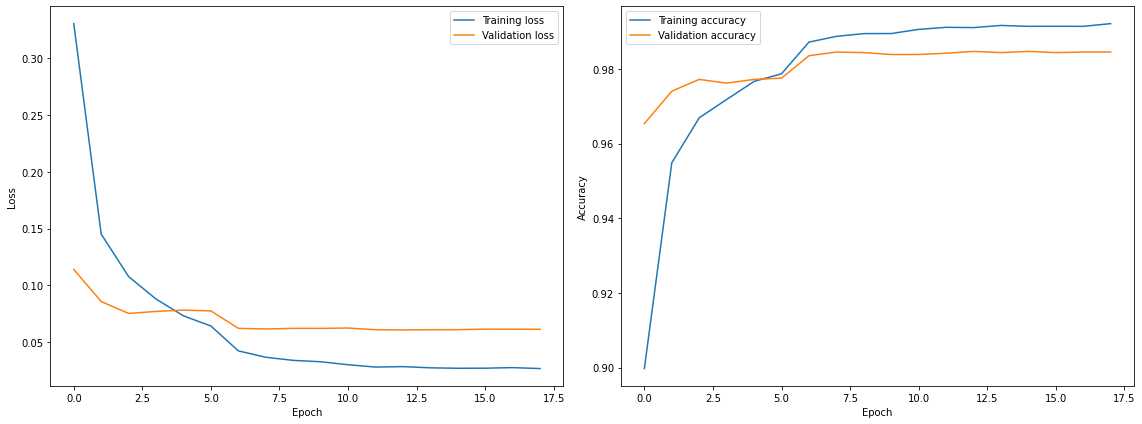

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')

ax[0].legend()
ax[0].set(
    ylabel='Loss',
    xlabel='Epoch'
)

ax[1].plot(history.history['acc'], label='Training accuracy')
ax[1].plot(history.history['val_acc'], label='Validation accuracy')

ax[1].set(
    ylabel='Accuracy',
    xlabel='Epoch'
)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
y_pred = [ np.argmax(pred) for pred in mlp.predict(x_test) ] 

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



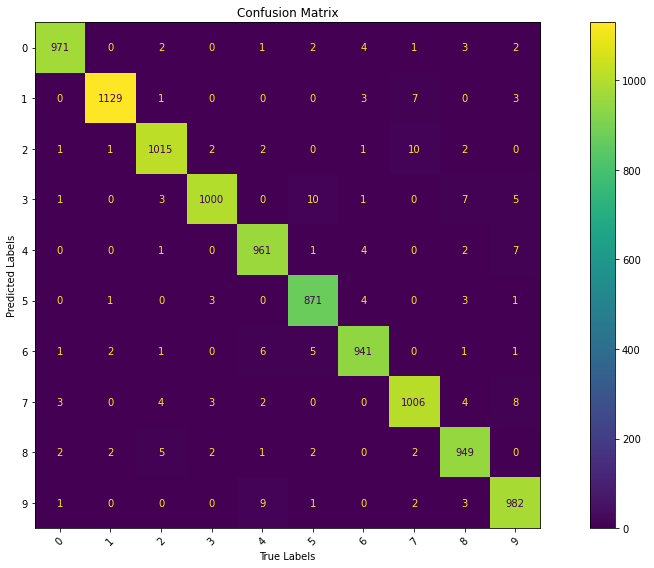

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))

ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_test, labels=list(range(10))),
    display_labels=list(range(10))
).plot(values_format='.0f', ax=ax)

ax.set(
    title='Confusion Matrix',
    xlabel='True Labels',
    ylabel='Predicted Labels'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

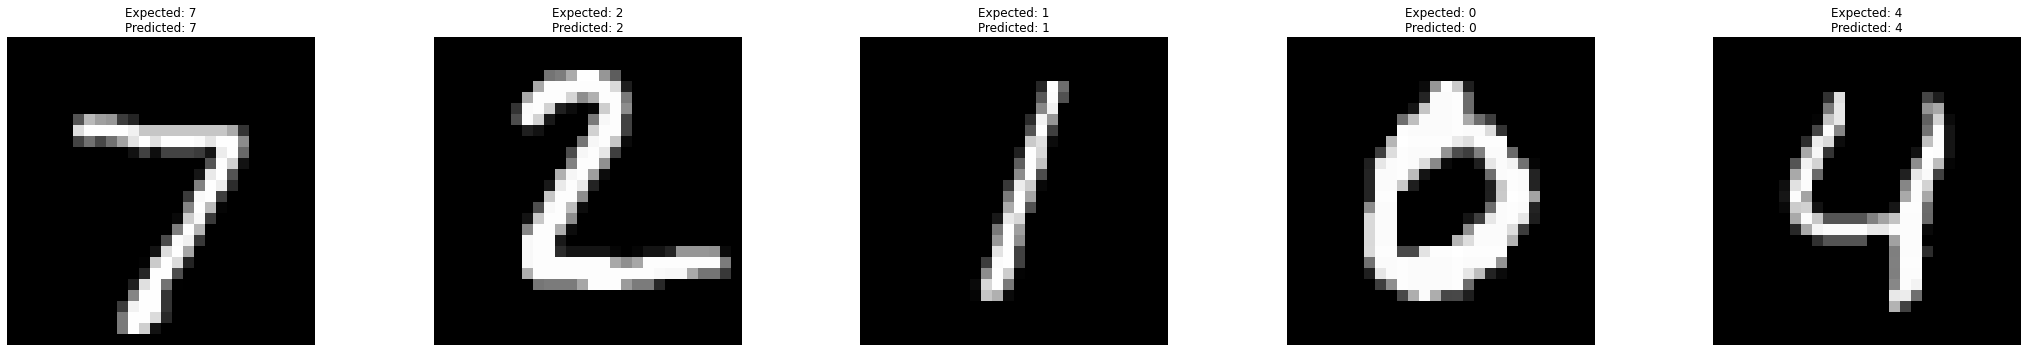

In [14]:
fig, ax = plt.subplots(ncols=5, figsize=(30, 5))

for idx, image in enumerate(x_test[:5]):

    ax[idx].imshow(image, cmap='gray')
    ax[idx].axis('off')

    ax[idx].set_title(f'Expected: {y_test[idx]}\nPredicted: {y_pred[idx]}')

plt.tight_layout()
plt.show()

### Saving model to Weights and Biases

In [15]:
mlp.save('mlp_model.h5')

In [16]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
run = wandb.init(project='proj_mnist', job_type='model')
wandb.save('mlp_model.h5')

wandb: Currently logged in as: xarmison. Use `wandb login --relogin` to force relogin


['/content/wandb/run-20220721_012752-2tusdd3p/files/mlp_model.h5']

## Modelo MLP com Autoencoder

In [ ]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.latent_dim = latent_dim   
        
        self.encoder = Sequential([
            Flatten(),
            Dense(1024, activation='relu'),
            Dropout(0.1),
            Dense(512, activation='relu'),
            Dropout(0.1),
            Dense(latent_dim, activation='relu'),
        ])

        self.decoder = Sequential([
            Dense(1024, activation='relu'),
            Dropout(0.1),
            Dense(512, activation='relu'),
            Dropout(0.1),
            Dense(784, activation='sigmoid'),
            Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [ ]:
autoencoder = Autoencoder(100)

autoencoder.compile(
    loss='mse',
    optimizer='adam',
)

In [ ]:
history = autoencoder.fit(
    x_train, x_train,
    validation_split=0.1,
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
    ]
)


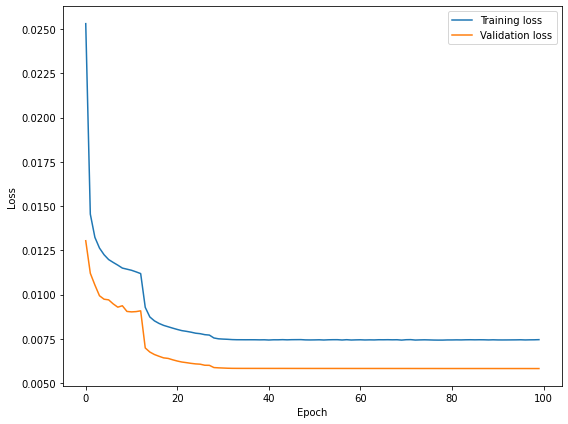

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')

ax.legend()
ax.set(
    ylabel='Loss',
    xlabel='Epoch'
)


plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
encoded_train_imgs = autoencoder.encoder(x_train).numpy()

encoded_test_imgs = autoencoder.encoder(x_test).numpy()
decoded_test_imgs = autoencoder.decoder(encoded_test_imgs).numpy()

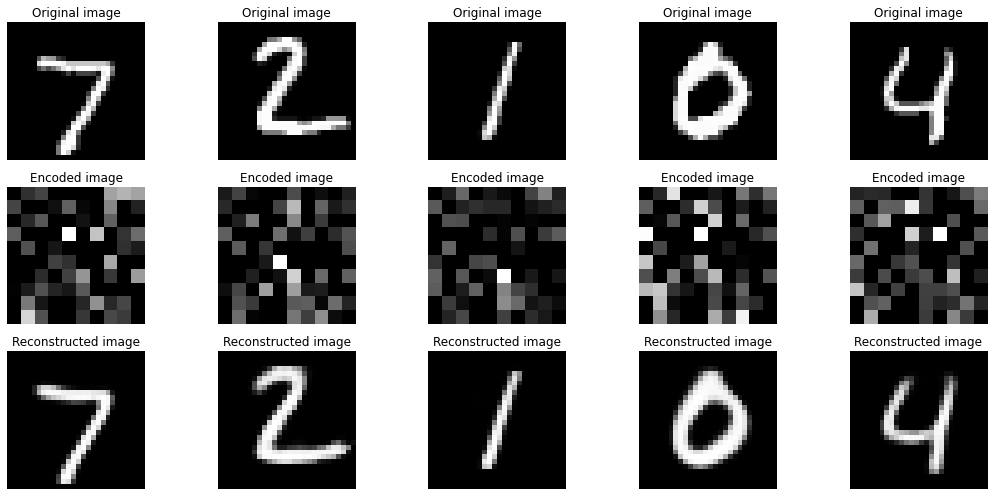

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 7))

for idx in range(5):
    # Original image
    ax[0][idx].imshow(x_test[idx], cmap='gray')

    ax[0][idx].set_title('Original image')
    
    ax[0][idx].axis('off')

    #Encoded imgae
    ax[1][idx].imshow(encoded_test_imgs[idx].reshape(10, 10), cmap='gray')

    ax[1][idx].set_title('Encoded image')
    
    ax[1][idx].axis('off')


    # Reconstructed image
    ax[2][idx].imshow(decoded_test_imgs[idx], cmap='gray')

    ax[2][idx].set_title('Reconstructed image')
    
    ax[2][idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(100,)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

mlp.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

mlp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               12928     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = mlp.fit(
    encoded_train_imgs, y_train,
    validation_split=0.1,
    batch_size=64,
    epochs=2000,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
    ]
)

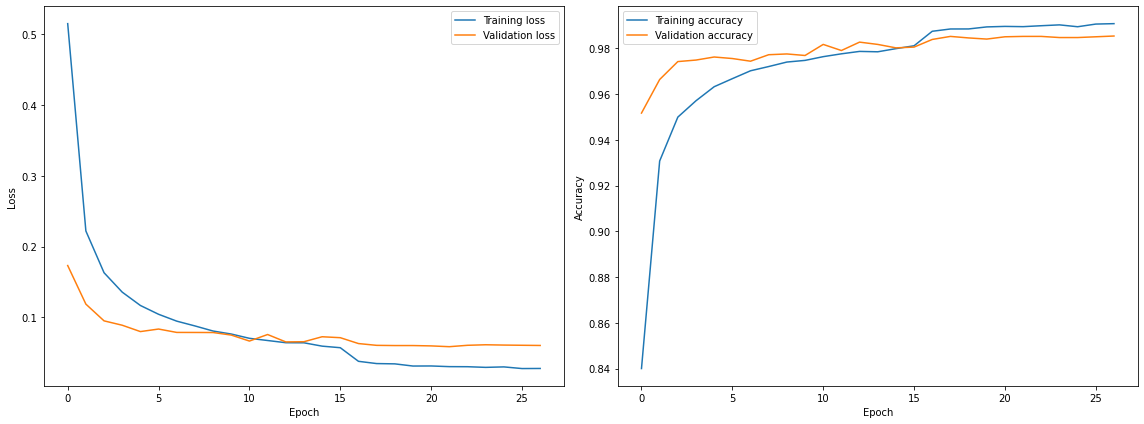

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')

ax[0].legend()
ax[0].set(
    ylabel='Loss',
    xlabel='Epoch'
)

ax[1].plot(history.history['acc'], label='Training accuracy')
ax[1].plot(history.history['val_acc'], label='Validation accuracy')

ax[1].set(
    ylabel='Accuracy',
    xlabel='Epoch'
)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_pred = [ np.argmax(pred) for pred in mlp.predict(encoded_test_imgs) ] 

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.99      0.98      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



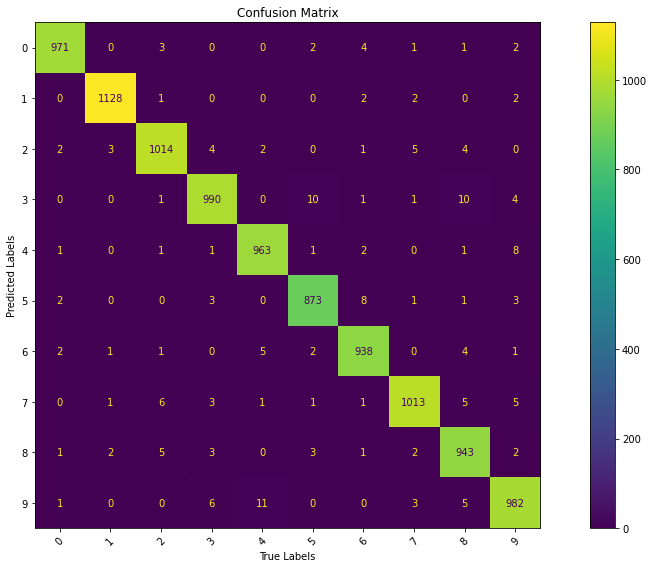

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_test, labels=list(range(10))),
    display_labels=list(range(10))
).plot(values_format='.0f', ax=ax)

ax.set(
    title='Confusion Matrix',
    xlabel='True Labels',
    ylabel='Predicted Labels'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

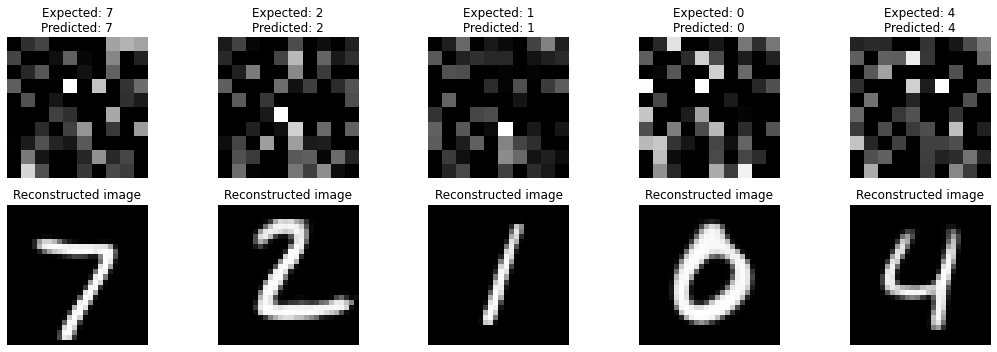

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))

for idx in range(5):
    # Original image
    ax[0][idx].imshow(encoded_test_imgs[idx].reshape(10, 10), cmap='gray')

    ax[0][idx].set_title(f'Expected: {y_test[idx]}\nPredicted: {y_pred[idx]}')
    
    ax[0][idx].axis('off')

    # Reconstructed image
    ax[1][idx].imshow(decoded_test_imgs[idx], cmap='gray')

    ax[1][idx].set_title('Reconstructed image')
    
    ax[1][idx].axis('off')

plt.tight_layout()
plt.show()


## Modelo com Autoencoders Convolucionais

In [ ]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.latent_dim = latent_dim   
        
        self.encoder = Sequential([
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (2, 2), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(16, (2, 2), activation='relu', padding='same'),
            Conv2D(4, (2, 2), activation='relu', padding='same'),
            Conv2D(1, (2, 2), activation='relu', padding='same'),
            Flatten(),
            Dense(latent_dim, activation='relu'),
        ])

        self.decoder = Sequential([
            Dense(4, activation='relu'),
            Reshape((2, 2, 1)),
            Conv2D(4, (2, 2), activation='relu', padding='same'),
            Conv2D(16, (2, 2), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((7, 7)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

history = autoencoder.fit(
    x_train, x_train,
    validation_split=0.1,
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
    ]
)

In [ ]:
encoded_train_imgs = autoencoder.encoder(x_train).numpy()

encoded_test_imgs = autoencoder.encoder(x_test).numpy()
decoded_test_imgs = autoencoder.decoder(encoded_test_imgs).numpy()

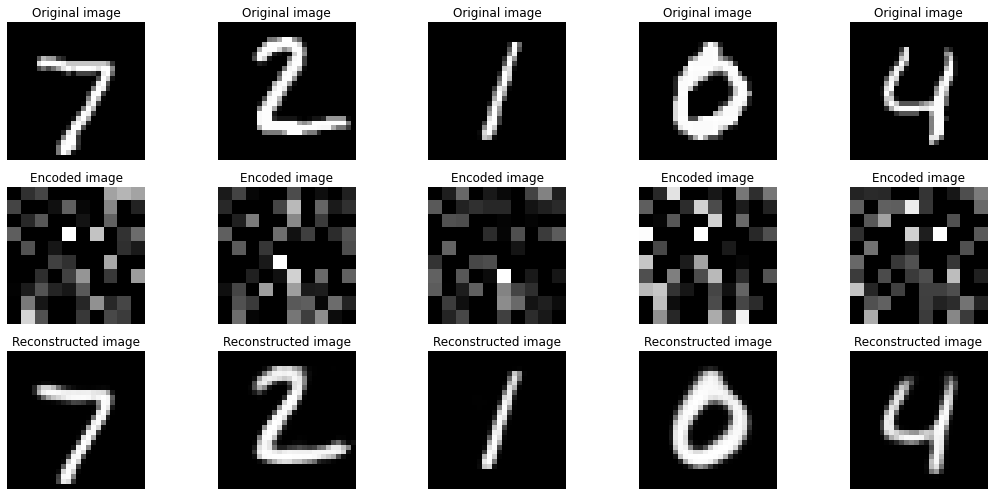

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 7))

for idx in range(5):
    # Original image
    ax[0][idx].imshow(x_test[idx].reshape((28, 28)), cmap='gray')

    ax[0][idx].set_title('Original image')
    
    ax[0][idx].axis('off')

    #Encoded imgae
    ax[1][idx].imshow(encoded_test_imgs[idx].reshape(10, 10), cmap='gray')

    ax[1][idx].set_title('Encoded image')
    
    ax[1][idx].axis('off')


    # Reconstructed image
    ax[2][idx].imshow(decoded_test_imgs[idx].reshape((28, 28)), cmap='gray')

    ax[2][idx].set_title('Reconstructed image')
    
    ax[2][idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(100,)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

mlp.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

mlp.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               12928     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 10)                1290      
                                                                 
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = mlp.fit(
    encoded_train_imgs, y_train,
    validation_split=0.1,
    batch_size=64,
    epochs=2000,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
    ]
)

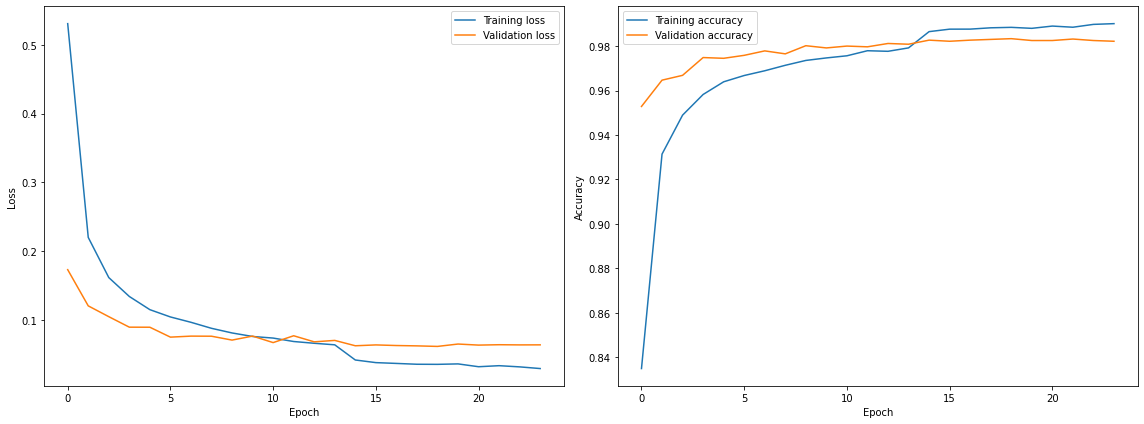

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')

ax[0].legend()
ax[0].set(
    ylabel='Loss',
    xlabel='Epoch'
)

ax[1].plot(history.history['acc'], label='Training accuracy')
ax[1].plot(history.history['val_acc'], label='Validation accuracy')

ax[1].set(
    ylabel='Accuracy',
    xlabel='Epoch'
)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_pred = [ np.argmax(pred) for pred in mlp.predict(encoded_test_imgs) ] 

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



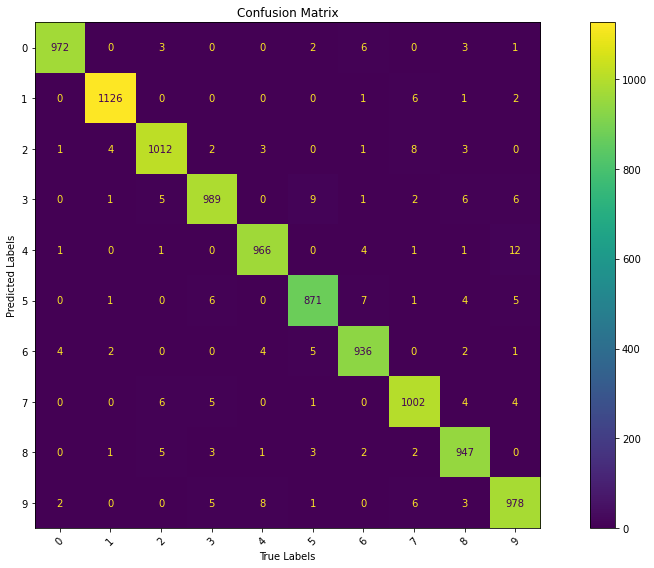

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_test, labels=list(range(10))),
    display_labels=list(range(10))
).plot(values_format='.0f', ax=ax)

ax.set(
    title='Confusion Matrix',
    xlabel='True Labels',
    ylabel='Predicted Labels'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

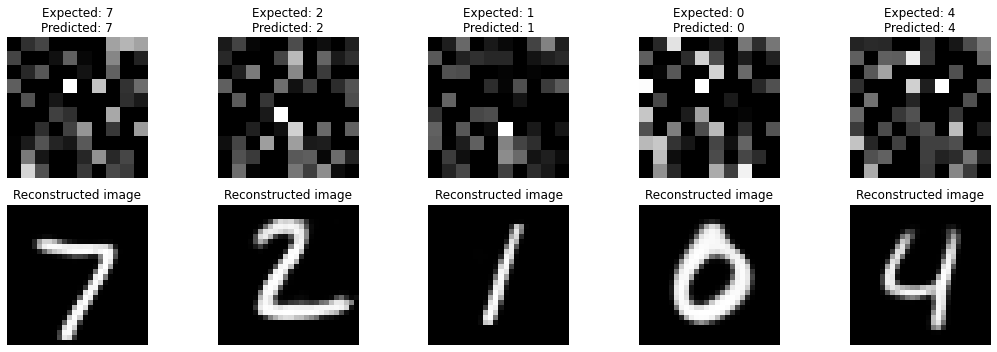

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))

for idx in range(5):
    # Original image
    ax[0][idx].imshow(encoded_test_imgs[idx].reshape(10, 10), cmap='gray')

    ax[0][idx].set_title(f'Expected: {y_test[idx]}\nPredicted: {y_pred[idx]}')
    
    ax[0][idx].axis('off')

    # Reconstructed image
    ax[1][idx].imshow(decoded_test_imgs[idx], cmap='gray')

    ax[1][idx].set_title('Reconstructed image')
    
    ax[1][idx].axis('off')

plt.tight_layout()
plt.show()


## Otimizando o Modelo de Classificação

In [ ]:
from wandb.keras import WandbCallback
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

In [ ]:
def Model():
    return Sequential([
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value

    
def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

In [ ]:
def train(
    train_dataset,
    val_dataset, 
    model,
    optimizer,
    loss_fn,
    train_acc_metric,
    val_acc_metric,
    epochs=10, 
    log_step=200, 
    val_log_step=50
):
  
    for epoch in range(epochs):
        print(f'\nEpoch # {epoch}')

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for _, (x_batch_train, y_batch_train) in tqdm(enumerate(train_dataset), total=len(train_dataset)):
            loss_value = train_step(
                x_batch_train, y_batch_train, 
                model, optimizer, 
                loss_fn, train_acc_metric
            )

            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for _, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(
                x_batch_val, y_batch_val, 
                model, loss_fn, 
                val_acc_metric
            )
            
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print(f'Training acc over epoch: {float(train_acc):.3f}')

        val_acc = val_acc_metric.result()
        print(f'Validation acc: {float(val_acc):.3f}')

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        wandb.log({
            'epochs': epoch,
            'loss': np.mean(train_loss),
            'acc': float(train_acc), 
            'val_loss': np.mean(val_loss),
            'val_acc': float(val_acc)
        })

In [ ]:
sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'early_terminate':{
        'type': 'hyperband',
        'min_iter': 5
    },
    'parameters': {
        'batch_size': {
            'values': [32, 64, 128, 256]
        },
        'learning_rate':{
            'values': [0.01, 0.005, 0.001, 0.0005, 0.0001]
        }
    }
}

In [ ]:
def sweep_train(config_defaults=None):
    # Set default values
    config_defaults = {
        'batch_size': 64,
        'learning_rate': 0.01
    }

    # Initialize wandb with a sample project name
    wandb.init(config=config_defaults)  # this gets over-written in the Sweep

    # Specify the other hyperparameters to the configuration, if any
    wandb.config.epochs = 2
    wandb.config.log_step = 20
    wandb.config.val_log_step = 50
    wandb.config.architecture_name = 'MLP'
    wandb.config.dataset_name = 'MNIST'

    # build input pipeline using tf.data
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = (train_dataset
        .shuffle(buffer_size=1024)
        .batch(wandb.config.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = (val_dataset
        .batch(wandb.config.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # initialize model
    model = Model()

    # Instantiate an optimizer to train the model.
    optimizer = SGD(learning_rate=wandb.config.learning_rate)
    # Instantiate a loss function.
    loss_fn = SparseCategoricalCrossentropy(from_logits=True)

    # Prepare the metrics.
    train_acc_metric = SparseCategoricalAccuracy()
    val_acc_metric = SparseCategoricalAccuracy()

    train(
        train_dataset,
        val_dataset, 
        model,
        optimizer,
        loss_fn,
        train_acc_metric,
        val_acc_metric,
        epochs=wandb.config.epochs, 
        log_step=wandb.config.log_step, 
        val_log_step=wandb.config.val_log_step
    )

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='proj_mnist_nn')

Create sweep with ID: o6uheunk
Sweep URL: https://wandb.ai/xarmison/proj_mnist_nn/sweeps/o6uheunk


In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=10)

wandb: Agent Starting Run: otn6ktqg with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.001
wandb: Currently logged in as: xarmison. Use `wandb login --relogin` to force relogin



Epoch # 0


  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
100%|██████████| 235/235 [00:02<00:00, 98.46it/s] 


Training acc over epoch: 0.148
Validation acc: 0.193

Epoch # 1


100%|██████████| 235/235 [00:02<00:00, 113.22it/s]


Training acc over epoch: 0.273
Validation acc: 0.364


acc,▁█
epochs,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.27287
epochs,1
loss,2.19537
val_acc,0.3644
val_loss,2.13001


wandb: Agent Starting Run: c4r01bw0 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01



Epoch # 0


100%|██████████| 938/938 [00:07<00:00, 124.17it/s]


Training acc over epoch: 0.769
Validation acc: 0.885

Epoch # 1


100%|██████████| 938/938 [00:07<00:00, 122.24it/s]


Training acc over epoch: 0.895
Validation acc: 0.908


acc,▁█
epochs,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.89512
epochs,1
loss,0.3707
val_acc,0.9079
val_loss,0.31667


wandb: Agent Starting Run: hnk5wxo8 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.005



Epoch # 0


100%|██████████| 469/469 [00:03<00:00, 118.38it/s]


Training acc over epoch: 0.575
Validation acc: 0.782

Epoch # 1


100%|██████████| 469/469 [00:03<00:00, 119.61it/s]


Training acc over epoch: 0.815
Validation acc: 0.848


acc,▁█
epochs,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.81472
epochs,1
loss,0.80167
val_acc,0.8482
val_loss,0.60295


wandb: Agent Starting Run: rojelv47 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.005



Epoch # 0


100%|██████████| 938/938 [00:07<00:00, 121.75it/s]


Training acc over epoch: 0.683
Validation acc: 0.848

Epoch # 1


100%|██████████| 938/938 [00:07<00:00, 122.98it/s]


Training acc over epoch: 0.866
Validation acc: 0.888


acc,▁█
epochs,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.86582
epochs,1
loss,0.51177
val_acc,0.888
val_loss,0.40806


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4j7nuhn1 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001



Epoch # 0


100%|██████████| 938/938 [00:07<00:00, 122.99it/s]


Training acc over epoch: 0.073
Validation acc: 0.086

Epoch # 1


100%|██████████| 938/938 [00:07<00:00, 124.18it/s]


Training acc over epoch: 0.102
Validation acc: 0.119


acc,▁█
epochs,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.10238
epochs,1
loss,2.31577
val_acc,0.1195
val_loss,2.29395


wandb: Agent Starting Run: hwoxbx74 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001



Epoch # 0


100%|██████████| 469/469 [00:04<00:00, 115.98it/s]


Training acc over epoch: 0.206
Validation acc: 0.361

Epoch # 1


100%|██████████| 469/469 [00:03<00:00, 118.00it/s]


Training acc over epoch: 0.499
Validation acc: 0.604


acc,▁█
epochs,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.49883
epochs,1
loss,2.02202
val_acc,0.6042
val_loss,1.89355


wandb: Agent Starting Run: zmhjlvkh with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0005



Epoch # 0


100%|██████████| 938/938 [00:07<00:00, 122.38it/s]


Training acc over epoch: 0.240
Validation acc: 0.373

Epoch # 1


100%|██████████| 938/938 [00:07<00:00, 122.26it/s]


Training acc over epoch: 0.462
Validation acc: 0.588


acc,▁█
epochs,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.46237
epochs,1
loss,1.99897
val_acc,0.5884
val_loss,1.86763


wandb: Agent Starting Run: 327b9ntj with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.005



Epoch # 0


100%|██████████| 235/235 [00:02<00:00, 110.07it/s]


Training acc over epoch: 0.368
Validation acc: 0.577

Epoch # 1


100%|██████████| 235/235 [00:02<00:00, 112.70it/s]


Training acc over epoch: 0.688
Validation acc: 0.764


acc,▁█
epochs,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.68815
epochs,1
loss,1.44577
val_acc,0.7639
val_loss,1.12475


wandb: Agent Starting Run: 58j8k98b with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.005



Epoch # 0


100%|██████████| 235/235 [00:02<00:00, 108.26it/s]


Training acc over epoch: 0.364
Validation acc: 0.607

Epoch # 1


100%|██████████| 235/235 [00:02<00:00, 111.21it/s]


Training acc over epoch: 0.673
Validation acc: 0.740


acc,▁█
epochs,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.67292
epochs,1
loss,1.59919
val_acc,0.7397
val_loss,1.27473


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gquoj5zb with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001



Epoch # 0


100%|██████████| 938/938 [00:07<00:00, 117.88it/s]


Training acc over epoch: 0.329
Validation acc: 0.553

Epoch # 1


100%|██████████| 938/938 [00:07<00:00, 121.31it/s]


Training acc over epoch: 0.654
Validation acc: 0.733


acc,▁█
epochs,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.65422
epochs,1
loss,1.66054
val_acc,0.7328
val_loss,1.37375
